<a href="https://colab.research.google.com/github/hussamalafandi/Generative_AI/blob/main/01/01_Autoencoders.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="display: inline; margin: 0 auto; float: right;"\>
</a>

# Autoencoders

**Autoencoders** are neural networks designed to learn efficient representations of data by encoding and decoding it.  
- **Architecture:**  
    - **Encoder:** Maps input data to a lower-dimensional latent space.  
    - **Decoder:** Reconstructs the original input from the latent representation.  
- **Loss Function:** Measures the difference between the input and its reconstruction, often using Mean Squared Error (MSE).  
- **Latent Space:**  
    - Captures compressed, meaningful features of the data.  
    - Enables tasks like interpolation and semantic transformations.  

<img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/b6/f4/variational-autoencoder-neural-network.png" width="900" style="display: block; margin: auto;">

*Image Source: [ibm.com](https://www.ibm.com/de-de/think/topics/variational-autoencoder)*

## Building an MNIST Autoencoder with PyTorch

In this section, we will create and train a basic autoencoder on the MNIST dataset using PyTorch.

We will start by importing the necessary libraries.

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt

## Weights and Biases
To track our experiments and monitor the model's progress during training, we will use [WandB](https://wandb.ai). To do so, you need to create an account and install WandB using `pip install wandb`. Once installed, initialize it for each project as follows:

In [2]:
import wandb
wandb.login()  # only needed once per machine/session

config = {
    "epochs": 20,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "architecture": "Autoencoder",
    "dataset": "MNIST",
    "latent_dim": 2
    }

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hussam-alafandi to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load the MNIST Dataset

We use the torchvision `MNIST` dataset class and apply a basic transformation to convert images to tensors.


In [3]:
# Load MNIST dataset
transform = ToTensor() # Convert images to PyTorch tensors and normalize to [0, 1]

train_data = MNIST(root='./data', train=True, transform=transform, download=True)
val_data = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=True)

## Define the Autoencoder Model

The autoencoder has two main parts:  
- **Encoder:** Compresses the 28x28 image into a smaller latent vector  
- **Decoder:** Reconstructs the image from the latent vector  
We use linear layers with ReLU activations and end the decoder with a sigmoid activation.


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, config["latent_dim"])
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(config["latent_dim"], 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_flat = x.flatten(start_dim=1)

        latent_tensor = self.encoder(x_flat)
        decoded = self.decoder(latent_tensor)

        return decoded.reshape_as(x)


## Initialize the Model, Loss Function, and Optimizer

We’ll use:
- **MSELoss** to measure reconstruction error, which calculates the mean squared error between the input $x$ and reconstructed output $\hat{x}$. The equation is:  
    $$
    \text{MSELoss} = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2
    $$
    This helps the model learn to minimize the difference between the original and reconstructed data.

    
- **Adam** optimizer for training, which combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. It computes adaptive learning rates for each parameter. 


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=1e-5)


Using device: cuda


## Create Evaluation Methods

We will evaluate the performance of the trained autoencoder by visualizing the reconstructed images and comparing them to the original inputs. This will help us understand how well the model has learned to compress and reconstruct the MNIST dataset.

In [6]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    return val_loss / len(dataloader)

In [7]:
import matplotlib.pyplot as plt

def plot_reconstruction_images(model, dataloader, device, n=6):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    # Plot original and reconstructed
    fig, axs = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axs[0, i].imshow(images[i].squeeze().cpu(), cmap="gray")
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")
        axs[1, i].imshow(outputs[i].squeeze().cpu(), cmap="gray")
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis("off")
    plt.tight_layout()
    return fig


The previous two methods demonstrate the model's reconstruction capabilities, showing how well it can recreate input images. However, it is also important to evaluate how random samples from the latent space are decoded into the full image space.

The next method generates random samples from the latent space, feeds them into the decoder, and returns the generated images.

In [8]:
def sample_random_latents(model, latent_dim, num_samples=6, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decoder(z).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axes[i].imshow(generated[i].view(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Random Samples from Vanilla Autoencoder Latent Space", fontsize=14)
    plt.tight_layout()

    return fig

## Train the Autoencoder

Loop through the dataset for multiple epochs.  
For each batch:
- Forward pass through the model  
- Compute the loss  
- Backpropagate and update weights  
- Track the loss for monitoring


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    wandb.init(
        project="mnist-autoencoder",
        config=config
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, images)
            loss.backward()

            optimizer.step()
            
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
        })

        print(f"Epoch {epoch+1}/{wandb.config.epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Every 5 epochs: log images
        if (epoch + 1) % 5 == 0:
            fig = plot_reconstruction_images(model, val_loader, device, n=6)
            wandb.log({"reconstruction_images": wandb.Image(fig)})

            plt.show()
            plt.close(fig)

            fig = sample_random_latents(model, num_samples=6, latent_dim=config["latent_dim"], device=device)
            wandb.log({"random_latent_samples": wandb.Image(fig)})
            plt.show()
            plt.close(fig)

    wandb.finish()

    return model, avg_train_loss, avg_val_loss



## Save or Load the Trained Model

In this step, we check if a saved model file exists. If it does, the model is loaded to avoid retraining. Otherwise, the model is trained from scratch, and the trained model is saved for future use. This approach saves time and computational resources by reusing previously trained models when available.


Model file found. Loading the model...


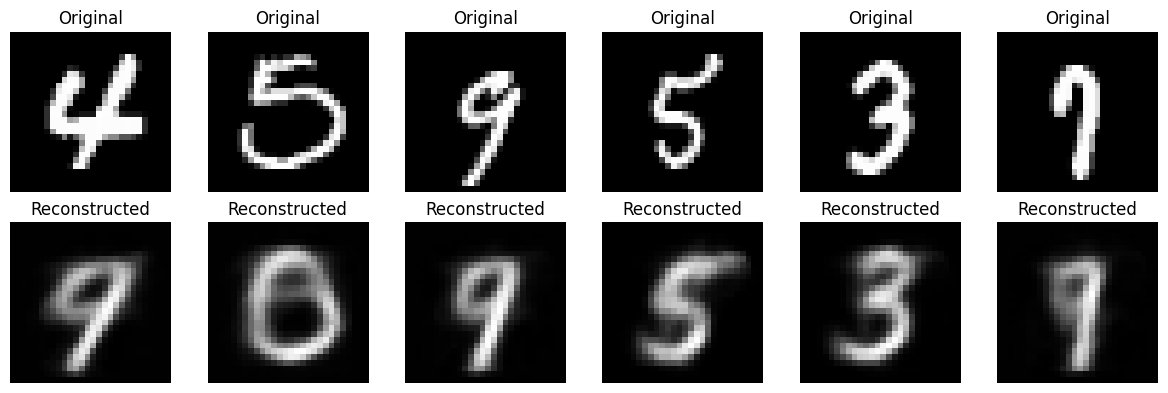

In [10]:
from pathlib import Path

model_dir = "./models/autoencoder-mnist"

# Check if the model file exists
model_path = Path(model_dir) / f"autoencoder_mnist_latent_{config['latent_dim']}_epochs_{config['epochs']}.pth"

if model_path.exists():
    print("Model file found. Loading the model...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    fig = plot_reconstruction_images(model, val_loader, device, n=6)
    plt.show()
else:
    print("Model file not found. Training the model...")
    # Train the model
    model, avg_train_loss, avg_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, config["epochs"])

    # Save the trained model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

## Visualize the Latent Space

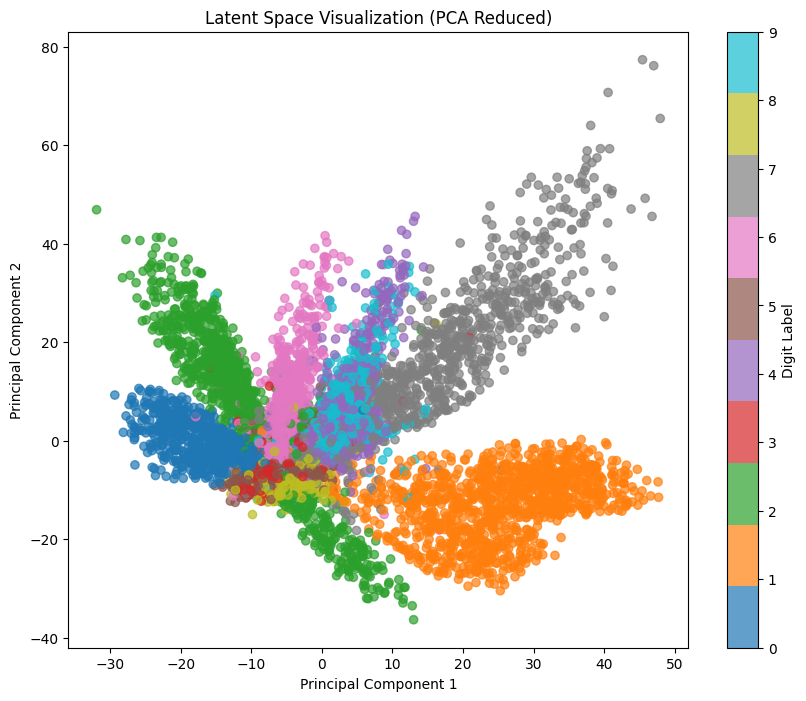

In [11]:
from sklearn.decomposition import PCA

def visualize_latent_space(autoencoder, dataloader, device):
    autoencoder.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            encoded = autoencoder.encoder(images.view(images.size(0), -1))
            latent_vectors.append(encoded.cpu())
            labels.append(targets)

    latent_vectors = torch.cat(latent_vectors)
    labels = torch.cat(labels)

    # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_latent_vectors = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent_vectors[:, 0], reduced_latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Digit Label")
    plt.title("Latent Space Visualization (PCA Reduced)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Visualize the latent space using the validation data
visualize_latent_space(model, val_loader, device)

## **Exercise**

modify the previous autoencoder to use convolutional layers instead of linear layers and compare their performance

## **Exercise**

test the vanilla auto encoder and the CNN autoencoder for fashion mnist dataset

# Variational Autoencoders (VAEs)

**Motivation for VAEs:**
- **Regularization:** VAEs enforce a continuous, smooth latent space by modeling the encoder output as a probability distribution.
- **Key Components:**  
  - **KL Divergence:** A regularization term that encourages the latent distribution to be close to a prior (usually a standard Gaussian).
  - **Reparameterization Trick:** Allows backpropagation through stochastic nodes.
- **Benefits:**  
  - Smooth interpolation between data points.
  - More meaningful manipulations in the latent space.


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*r1R0cxCnErWgE0P4Q-hI0Q.jpeg" width="900" style="display: block; margin: auto;">

*Image Source: [medium.com](https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68)*

## VAE with CelebA

In this section, we’ll work with a VAE on the CelebA dataset. The goals are:
- Load and preprocess the CelebA dataset.
- Define and (optionally) load a pretrained VAE model.
- Encode images to obtain their latent representations.
- Interpolate between latent vectors and decode the results to see how the generated images change.

**Note:** Training a VAE on CelebA from scratch is computationally intensive. For this demonstration, you can either:
- Use a pretrained model checkpoint (if available), or
- Train a simplified model on a subset of the dataset for a few epochs.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np


# Check device
if not torch.cuda.is_available():
    raise RuntimeError("No GPU available. Please run on a machine with a GPU.")

# Set device
device = torch.device("cuda")
print("Using device:", device)

vae_config = {
    "epochs": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "architecture": "VAE",
    "dataset": "CelebA",
    "latent_dim": 200,
    "subset_size": 80000
}


Using device: cuda


Data Preparation - Load CelebA (subset)

In [13]:
# Define transformations for the CelebA dataset
celeba_transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),  # Resize to a smaller size for quick experimentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the CelebA dataset
celeba_train_dataset = datasets.CelebA(root='../data', split='train', transform=celeba_transform, download=True)
celeba_val_dataset = datasets.CelebA(root='../data', split='valid', transform=celeba_transform, download=True)

# Subset the CelebA dataset for quick experimentation
train_subset_size = vae_config["subset_size"]  # Use a smaller subset of the training dataset
train_subset_indices = list(range(train_subset_size))
celeba_train_subset = torch.utils.data.Subset(celeba_train_dataset, train_subset_indices)

val_subset_size = 10000  # Use a smaller subset of the validation dataset
val_subset_indices = list(range(val_subset_size))
celeba_val_subset = torch.utils.data.Subset(celeba_val_dataset, val_subset_indices)

# Create DataLoaders for training and validation subsets
celeba_train_loader = DataLoader(celeba_train_subset, batch_size=vae_config["batch_size"], shuffle=True)
celeba_val_loader = DataLoader(celeba_val_subset, batch_size=vae_config["batch_size"], shuffle=False)

# Print dataset sizes
print("Number of images in training subset:", len(celeba_train_subset))
print("Number of images in validation subset:", len(celeba_val_subset))


Number of images in training subset: 80000
Number of images in validation subset: 10000


## Defining a Simple VAE Model

Below is a simplified convolutional VAE model. In a real-world course, you might provide a more refined architecture or a pretrained checkpoint. For this exercise, we define the model and show how to perform encoding and decoding.


In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8 -> 4
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256*4*4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 32 -> 64
            nn.Tanh()  # Output values in [-1, 1] due to normalization
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = torch.flatten(x_enc, start_dim=1)

        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        x_dec = self.decoder_input(z)
        x_dec = x_dec.reshape(-1, 256, 4, 4)
        x_recon = self.decoder(x_dec)
        return x_recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Initialize the VAE model and move it to the device
latent_dim = vae_config["latent_dim"]
model = VAE(latent_dim=latent_dim).to(device)
print(model)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=200, bias=True)
  (decoder_input): Linear(in_features=200, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2)

## Loss Function in VAE

The loss function in a Variational Autoencoder (VAE) combines two components:

1. **Reconstruction Loss**:  
    This measures how well the reconstructed output matches the original input. It ensures that the decoder learns to generate data similar to the input.  
    - In this notebook, the reconstruction loss is calculated using Mean Squared Error (MSE):
      $$
      \text{Reconstruction Loss} = \sum_{i=1}^{N} (x_i - \hat{x}_i)^2
      $$
      where $x_i$ is the original input, and $\hat{x}_i$ is the reconstructed output.

2. **KL Divergence (Regularization Term)**:  
    This term ensures that the latent space follows a standard Gaussian distribution. It measures the difference between the learned latent distribution $q(z|x)$ and the prior distribution $p(z)$ (usually a standard normal distribution).  
    - The KL Divergence is given by:
      $$
      \text{KL Divergence} = -\frac{1}{2} \sum_{j=1}^{D} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)
      $$
      where $\mu_j$ and $\sigma_j^2$ are the mean and variance of the latent distribution.

### Combined Loss:
The total loss is the sum of the reconstruction loss and the KL divergence:
$$
\text{VAE Loss} = \text{Reconstruction Loss} + \text{KL Divergence}
$$

This combined loss ensures that the VAE learns to reconstruct the input data while maintaining a smooth and continuous latent space, enabling meaningful interpolations and manipulations.

In [15]:
# Loss function components: Reconstruction Loss and KL Divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL Divergence
    kl_divergance = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergance, recon_loss, kl_divergance

optimizer = optim.Adam(model.parameters(), lr=vae_config["learning_rate"])


## Evaluation Methods

In this section, we define methods to evaluate the performance of our models. These methods include calculating the loss on validation datasets and visualizing the reconstructed images to assess the quality of the generated outputs.

In [16]:
def evaluate_vae(model, dataloader, device):
    """Evaluate the VAE model on a given dataset."""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, mu, logvar = model(images)

            loss, recon_loss, kl_loss = loss_function(recon_images, images, mu, logvar)
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_loss = total_kl_loss / len(dataloader.dataset)
    
    print(f"Evaluation Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")
    return avg_loss, avg_recon_loss, avg_kl_loss

def plot_vae_reconstructions(model, dataloader, device, n=6):
    """Plot original and reconstructed images from the VAE."""
    model.eval()
    images, _ = next(iter(dataloader))
    indices = torch.randperm(images.size(0))[:n]
    images = images[indices].to(device)
    with torch.no_grad():
        recon_images, _, _ = model(images)

    # Plot original and reconstructed images
    fig, axs = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        # Original images
        axs[0, i].imshow((images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")
        # Reconstructed images
        axs[1, i].imshow((recon_images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis("off")
    plt.tight_layout()
    return fig

def sample_random_latents_vae(model, latent_dim, num_samples=6, device='cuda'):
    """Sample random latent vectors and generate images from the VAE."""
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        axes[i].imshow((generated[i].permute(1, 2, 0).cpu().numpy() + 1) / 2)
        axes[i].axis('off')
    plt.suptitle("Random Samples from VAE Latent Space", fontsize=14)
    plt.tight_layout()

    return fig



## Define the Training Method

In [17]:
import wandb

def train_vae(model, train_loader, val_loader, optimizer, vae_config, wandb_mode='online'):
    """Train the VAE model with wandb logging and evaluation every 5 epochs."""
    wandb.init(
        project="vae-celeba",
        config=vae_config,
        mode=wandb_mode
    )

    for epoch in range(vae_config["epochs"]):
        model.train()
        train_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            recon_images, mu, logvar = model(images)

            loss, recon_loss, kl_loss = loss_function(recon_images, images, mu, logvar)
            loss.backward()

            train_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            optimizer.step()
        
        avg_loss = train_loss / len(train_loader.dataset)
        avg_recon_loss = total_recon_loss / len(train_loader.dataset)
        avg_kl_loss = total_kl_loss / len(train_loader.dataset)
        
        wandb.log({"epoch": epoch + 1, "train/loss": avg_loss, "train/recon_loss": avg_recon_loss, "train/kl_loss": avg_kl_loss})
        print(f"Epoch {epoch + 1}/{vae_config['epochs']}, Train Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")

        # Evaluate and log every 5 epochs
        if (epoch + 1) % 5 == 0:
            val_loss, avg_recon_loss, avg_kl_loss = evaluate_vae(model, val_loader, device)
            wandb.log({"epoch": epoch + 1, "val/loss": val_loss, "val/avg_recon_loss": avg_recon_loss, "val/avg_kl_loss": avg_kl_loss})

            fig = plot_vae_reconstructions(model, val_loader, device, n=6)
            plt.show()
            wandb.log({"val/reconstruction_images": wandb.Image(fig)})
            
            plt.close(fig)

    wandb.finish()
    return model, avg_loss, val_loss

Train or load the model

VAE model file found. Loading the model...


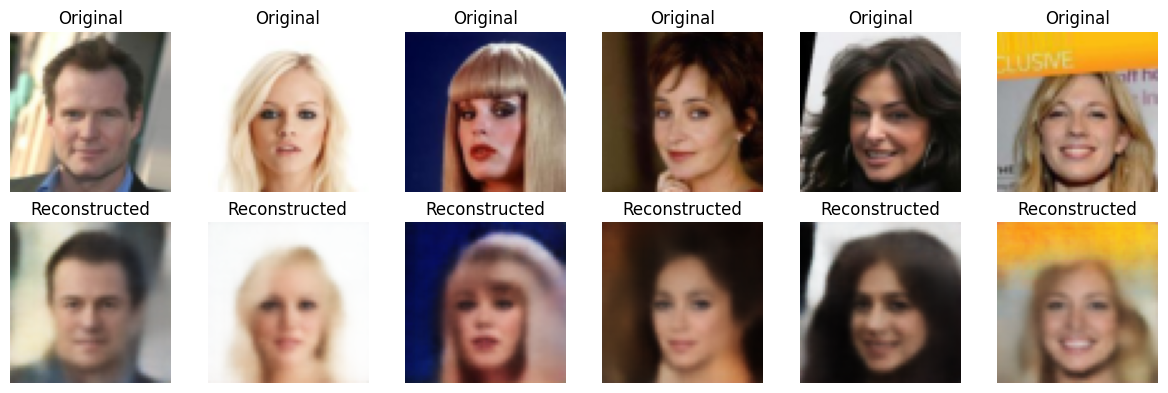

In [18]:
from pathlib import Path

# Define the model save path
vae_model_dir = "./models/vae-celeba"
vae_model_path = Path(vae_model_dir) / f"vae_celeba_latent_{vae_config['latent_dim']}_epochs_{vae_config['epochs']}_batch_{vae_config['batch_size']}_subset_{vae_config['subset_size']}.pth"

# Check if the model file exists
if vae_model_path.exists():
    print("VAE model file found. Loading the model...")
    model.load_state_dict(torch.load(vae_model_path))
    model.eval()
    fig = plot_vae_reconstructions(model, celeba_val_loader, device, n=6)
    plt.show()
else:
    print("VAE model file not found. Training the model...")
    # Train the model
    model, avg_train_loss, avg_val_loss = train_vae(model, celeba_train_loader, celeba_val_loader, optimizer, vae_config, wandb_mode='disabled')
    print(f"Training completed. Average training loss: {avg_train_loss}, Average validation loss: {avg_val_loss}")

    # Save the trained model
    vae_model_dir_path = Path(vae_model_dir)
    vae_model_dir_path.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), vae_model_path)
    print(f"VAE model saved to {vae_model_path}")

## Latent Space Manipulation & Interpolation

Now that our VAE is trained, let’s demonstrate latent space interpolation. We will:
1. Select two images from the dataset.
2. Encode them to obtain their latent vectors.
3. Linearly interpolate between the two latent vectors.
4. Decode each interpolated vector to visualize the transition between the two images.


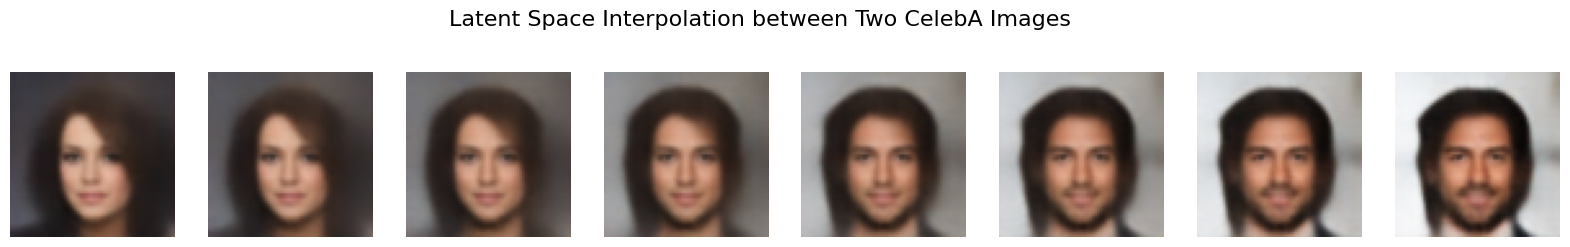

In [19]:
def interpolate(z1, z2, num_steps=8):
    """Generate a series of interpolated latent vectors between z1 and z2."""
    ratios = np.linspace(0, 1, num_steps)
    interpolated = [ (1 - r) * z1 + r * z2 for r in ratios ]
    return torch.stack(interpolated)

# Get two images from the dataset
data_iter = iter(celeba_val_loader)
images, _ = next(data_iter)
img1 = images[0].unsqueeze(0).to(device)
img2 = images[1].unsqueeze(0).to(device)

# Encode images
model.eval()
with torch.no_grad():
    mu1, _ = model.encode(img1)
    mu2, _ = model.encode(img2)

# Interpolate in the latent space
num_steps = 8
interpolated_z = interpolate(mu1, mu2, num_steps=num_steps)

# Decode the interpolated latent vectors
with torch.no_grad():
    decoded_imgs = model.decode(interpolated_z).cpu()

# Plot the interpolation results
fig, axes = plt.subplots(1, num_steps, figsize=(20, 3))
for i, ax in enumerate(axes):
    # Denormalize image from [-1,1] to [0,1]
    img = (decoded_imgs[i].permute(1, 2, 0).numpy() + 1) / 2.0
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
plt.suptitle("Latent Space Interpolation between Two CelebA Images", fontsize=16)
plt.show()


## CelebA Attributes (Indices for Binary Labels)

Another example we could try to manipulate the latent space so that it forces an image (a person) to have a specific characteristic. For example, we could change the image of a non-smiling person to a smiling image, change the hair color, etc.

The CelebA dataset comes with annotated characteristics of the images, where each image has the following annotated values (attributes) that specify which characteristics the person in the image has.


| **Index** | **Attribute**         | **Index** | **Attribute**         | **Index** | **Attribute**         |
|-----------|------------------------|-----------|------------------------|-----------|------------------------|
| **0**     | 5_o_Clock_Shadow       | **14**    | Double_Chin           | **28**    | Receding_Hairline     |
| **1**     | Arched_Eyebrows        | **15**    | Eyeglasses            | **29**    | Rosy_Cheeks           |
| **2**     | Attractive             | **16**    | Goatee                | **30**    | Sideburns             |
| **3**     | Bags_Under_Eyes        | **17**    | Gray_Hair             | **31**    | Smiling               |
| **4**     | Bald                   | **18**    | Heavy_Makeup          | **32**    | Straight_Hair         |
| **5**     | Bangs                  | **19**    | High_Cheekbones       | **33**    | Wavy_Hair             |
| **6**     | Big_Lips               | **20**    | Male                  | **34**    | Wearing_Earrings      |
| **7**     | Big_Nose               | **21**    | Mouth_Slightly_Open   | **35**    | Wearing_Hat           |
| **8**     | Black_Hair             | **22**    | Mustache              | **36**    | Wearing_Lipstick      |
| **9**     | Blond_Hair             | **23**    | Narrow_Eyes           | **37**    | Wearing_Necklace      |
| **10**    | Blurry                 | **24**    | No_Beard              | **38**    | Wearing_Necktie       |
| **11**    | Brown_Hair             | **25**    | Oval_Face             | **39**    | Young                 |
| **12**    | Bushy_Eyebrows         | **26**    | Pale_Skin             |           |                        |
| **13**    | Chubby                 | **27**    | Pointy_Nose           |           |                        |


The following function returns the latent space along with the values of a chosen attribute.

In [20]:
def get_latents_and_attrs(model, dataloader, attribute_idx):
    """Get latent vectors and corresponding attributes from the dataset."""
    x, a = next(iter(dataloader))
    x = x.to(device)
    with torch.no_grad():
        mu, _ = model.encode(x)
    latents = mu.cpu()
    attrs = a[:, attribute_idx].cpu()
    return latents, attrs


In the following, we collect the latent vectors and their corresponding attributes for one batch. We then manipulate the latent space by moving along a specific direction to generate an image with the desired attributes. The process is interpolated to visualize the gradual effect of moving along this direction in the latent space.

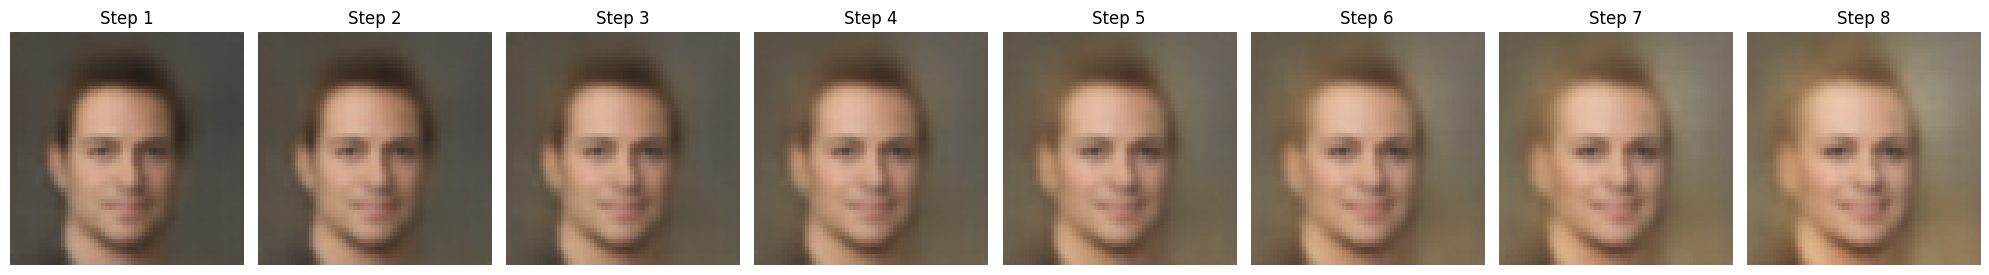

In [21]:
def visualize_attribute_interpolation(model, latents, attrs, num_steps=8, device='cuda'):
    """
    Visualize the interpolation of a specific attribute in the latent space.

    Args:
        model (nn.Module): The trained VAE model.
        latents (torch.Tensor): Latent representations of the dataset.
        attrs (torch.Tensor): Attribute labels corresponding to the dataset.
        attribute_idx (int): Index of the attribute to visualize.
        num_steps (int): Number of interpolation steps. Default is 8.
        device (str): Device to use ('cuda' or 'cpu'). Default is 'cuda'.
    """
    # Compute the direction vector for the attribute
    attribute_mean_positive = latents[attrs == 1].mean(dim=0)
    attribute_mean_negative = latents[attrs == 0].mean(dim=0)
    direction = attribute_mean_positive - attribute_mean_negative

    # Pick a random sample with the negative attribute
    negative_attribute_latent = latents[attrs == 0][10].unsqueeze(0)

    # Interpolate between the negative attribute and the positive attribute
    interpolated_latents = torch.stack([
        negative_attribute_latent + alpha * direction
        for alpha in torch.linspace(0, 1, num_steps)
    ]).to(device)

    # Decode the interpolated latent vectors
    with torch.no_grad():
        interpolated_faces = model.decode(interpolated_latents).cpu()

    # Plot the interpolation results
    fig, axes = plt.subplots(1, num_steps, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow((interpolated_faces[i].squeeze().permute(1, 2, 0).numpy() + 1) / 2)
        ax.set_title(f"Step {i + 1}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

attribute_idx = 9

latents, attrs = get_latents_and_attrs(model, celeba_val_loader, attribute_idx)
visualize_attribute_interpolation(model, latents, attrs, num_steps=8, device=device)


We can also generate new images of persons by sampling from the latent space.

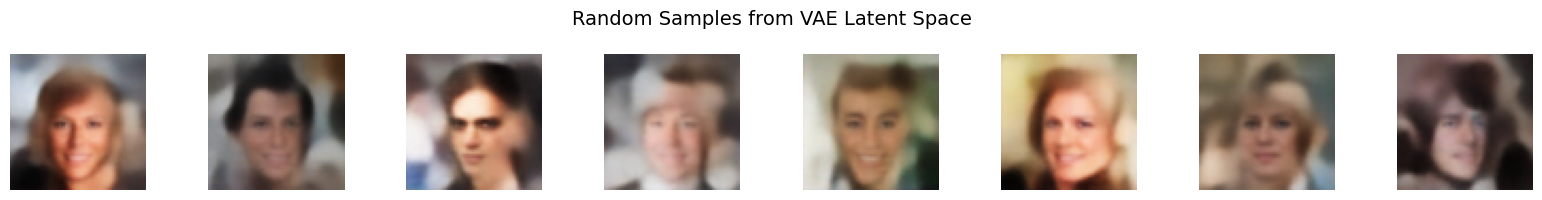

In [22]:
def sample_from_vae(model, latent_dim=200, num_samples=8, device='cuda'):
    """
    Sample random latent vectors from a standard Gaussian,
    decode them using the VAE decoder, and visualize the generated images.
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = model.decode(z).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = (generated[i].permute(1, 2, 0).numpy() + 1) / 2.0  # denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].axis('off')

    plt.suptitle("Random Samples from VAE Latent Space", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run it
sample_from_vae(model, latent_dim=vae_config["latent_dim"], device=device)


## Exercise

Train the VAE on the MNIST dataset and sample from its latent space. Compare the results with the vanilla autoencoder.

**Recommended Reading & Resources:**
- [What is latent space?](https://www.ibm.com/think/topics/latent-space)